## Changing DCM Energy and finding Max Flux

When we move from one energy to another with the DCM, we have to find the values of the undulator gap and the DCM 2nd Crystal Pitch that maximise intesity. 

This involves moving a diode into the path of the hard beam and performing some scans, then removing it

This notebook explores how we might put this into a plan/macro

In [1]:
#Set up the Run Engine enviroment that will run the plan

from bluesky.run_engine import RunEngine 

RE = RunEngine({})


In [2]:

#Set up plotting
from bluesky.callbacks.best_effort import BestEffortCallback
from event_model import RunRouter


def bec_factory(name, doc):
    # Documents from each run is routed to an independent
    #   instance of BestEffortCallback
    bec = BestEffortCallback()
    return [bec], []
bec_rr = RunRouter([bec_factory])
RE.subscribe(bec_rr)


0

# Creating Simulated Devices

We can create simulated versions of the devices we are interested in:

- dcm which has energy, 2nd crystal pitch positioner, id_control config and other config params
- u17 undulator which has a gap component. Also has ID control and some other params
- the diode in/out actuator
- the readout from the keithley

By creating simulated devices with the same names and parameter names as the real devices, we can develop our plan without real devices. 

In [3]:

from ophyd.sim import SynAxis, Syn2DGauss
from ophyd import Device, Component as Cpt, Signal
from bessyii_devices.sim import SimPositionerDone

class SimUndulatorGap(SimPositionerDone):

    """
    This is a simulation of the gap positioner for the undulator

    includes configuration parameters of vel, delta and models the parameter 'cmd'
    """
    def __init__(self, *args, **kwargs):
        super().__init__( **kwargs)
        self.readback.name = self.name 
    
    cmd = Cpt(Signal, kind ='config' )
    vel = Cpt(Signal, kind ='config' )
    delta = Cpt(Signal, kind ='config' )
    
    def stage(self):

        self.cmd.set('START')      # update the EPICS PV as quick as we can
        
        super().stage()


class SimUndulatorBase(Device): # PlanarDevice
    """
    contains only a gap positioner. A helical device would have gap and shift
    """
    
    gap = Cpt(SimUndulatorGap, kind="normal")
    
    # Commands
    id_control = Cpt(Signal, kind ='config' )
    cmd_stop   = Cpt(Signal, kind ='omitted' )  


    read_attrs = ['gap']



class SimDCM(Device):

    """
    DCM has an energy positioner, a positioner for the 2nd crystal pitch

    also config parameters for the id_on and enabling 2nd crystal translation
    """

    en = Cpt(SimPositionerDone,kind="normal")
    cr1 = Cpt(SimPositionerDone,kind="normal")
    c2t = Cpt(SimPositionerDone,kind="normal")
    ID_on = Cpt(Signal, kind ='config' )
    channelcut_disable = Cpt(Signal, kind ='config' )



# Instantiating Devices

Here we are going to create instances of the classes described above. Some of these class definitions are made elsewhere. 

We can connect the output of the keithley to both the u17 gap, and the u17_dcm crystal pitch

In [4]:

#simulation of the u17 undulator
u17 = SimUndulatorBase(name="u17", labels={"motors"})

#simulation of the u17_dcm
u17_dcm = SimDCM(name="u17_dcm")

#simulation of the actuator that moves the diode in and out
diode_motor = SimPositionerDone(name="diode_motor", labels={"motors"})

#simulation of the keithley connected to the diode after the DCM.
kth9 = Syn2DGauss(
        "kth9",
        u17_dcm.cr1,
        "u17_dcm_cr1",
        u17.gap, 
        "u17_gap",
        center=(310, 0.1),  # Simulate the optimal positon at crystal pitch 310uRad and id gap 0.1
        Imax=10,
        labels={"detectors"}
    )   




# Creating a Plan/Macro

We will create a plan which implements the following: https://nubes.helmholtz-berlin.de/s/GBsM2AHyYGoadjN

We use yield from because each of the other things we are calling like "configure", "scan", "mov", "tune_centroid" are themselves plans. 

We end up with a plan which is a collection of messages telling the devices to do things like move, read, trigger etc. 

In [5]:
# First some plans for controlling the undulator/mono interaction
from bluesky.plan_stubs import configure
def IDoff():

    yield from configure(u17,{"id_control":"local"})
    yield from configure(u17_dcm,{"ID_on":"0"})

def IDon():

    yield from configure(u17,{"id_control":"remote"})
    yield from configure(u17_dcm,{"ID_on":"1"})




# What are the plans doing?

We can look at the messages that form each of these simple plans

In [6]:
for item in IDon():

    print(item)

Msg('configure', obj=SimUndulatorBase(prefix='', name='u17', read_attrs=['gap'], configuration_attrs=['gap', 'gap.done', 'gap.velocity', 'gap.acceleration', 'gap.cmd', 'gap.vel', 'gap.delta', 'id_control']), args=({'id_control': 'remote'},), kwargs={}, run=None)
Msg('configure', obj=SimDCM(prefix='', name='u17_dcm', read_attrs=['en', 'en.readback', 'en.setpoint', 'cr1', 'cr1.readback', 'cr1.setpoint', 'c2t', 'c2t.readback', 'c2t.setpoint'], configuration_attrs=['en', 'en.done', 'en.velocity', 'en.acceleration', 'cr1', 'cr1.done', 'cr1.velocity', 'cr1.acceleration', 'c2t', 'c2t.done', 'c2t.velocity', 'c2t.acceleration', 'ID_on', 'channelcut_disable']), args=({'ID_on': '1'},), kwargs={}, run=None)


In [19]:

# import pre tested plans from the package
from bluesky.plan_stubs import mov
import bluesky.plan_stubs as bps
from bluesky.plans import scan, tune_centroid
from bluesky.preprocessors import relative_set_wrapper


def dcm_energy_creep(energy, num_attempts = 10,c2t_prc = 3.0):

    """
    This plan will move the DCM from it's current energy, to a new energy

    It will attempt this repeatedly until the c2t setpoint - readback is less than the c2t_prc

    It will attempt it num_attempts times

    arguments:

        energy: float
            The required energy to move to
        num_attempts : int
            The maximum number of times we will try to move the DCM energy and achieve required c2t
        c2t_prc : float
            The precision in um of the c2t setting when we move the energy
      
    
    """

    c2t_diff = c2t_prc+1.0 # initialise to allow loop to run initially
    attempts = 0

    # Repeatedly attempt to move the dcm energy and monitor the c2t difference
    while c2t_diff > c2t_prc and attempts < num_attempts:

        # move the energy to -100 below the desired energy, wait for it to get there
        print(f"Moving DCM Energy to {energy-100} ")
        yield from mov(u17_dcm.en,energy-100)

        # move the energy to -10 below the desired energy, wait for it to get there
        print(f"Moving DCM Energy to {energy-10} ")
        yield from mov(u17_dcm.en,energy-10)

        # move the energy to the desired energy, wait for it to get there
        print(f"Moving DCM Energy to {energy} ")
        yield from mov(u17_dcm.en,energy)

        c2t_diff = abs(u17_dcm.c2t.setpoint.get() -u17_dcm.c2t.readback.get())
        print(f"The difference between the ct2 setpoint and readback is {c2t_diff} ")
        attempts = attempts + 1

    if attempts >= num_attempts:

        msg = (
            f"Unable to make the c2t_diff less than {c2t_prc} in {num_attempts} attempts"
        )
        raise ValueError(msg)


def dcm_change_energy(energy, num_attempts = 10,c2t_prc = 3.0, gap_prec = 1, fbp_prec = 0.1):

    """
    This plan will move the DCM from it's current energy, to a new energy

    It will then find the optimal ID gap and DCM 2nd Crystal Pitch for max flux by measuring the current on kth9

    arguments:

        energy: float
            The required energy to move to
        num_attempts : int
            The maximum number of times we will try to move the DCM energy and achieve required c2t
        c2t_prc : float
            The precision in um of the c2t setting when we move the energy
        gap_prec: float (um)
            default(1)
            The required precision of the gap optimistation
        fbp_prec: float (urad)
            default(0.1)
            The required precision of the DCM 2nd Crystal Pitch optimisation
    
    """

    #ID off. mono should not control the undulator
    yield from IDoff()

    #disable 2nd crystal translation (ccoff)
    yield from configure(u17_dcm,{"channelcut_disable":"1"})

    # Move the dcm energy until the difference between the c2t setpoint and readback is less than c2t_prc, try num_attempts times
    yield from dcm_energy_creep(energy, num_attempts, c2t_prc)

    #enable 2nd crystal translation (ccoff)
    yield from configure(u17_dcm,{"channelcut_disable":"0"})

    #ID on. mono should control the undulator
    yield from IDon()

    #1 move in the diode, wait for it to finish
    yield from mov(diode_motor,100)

    #determine gap_0
    gap_0 = u17.gap.position

    #scan the undulator gap, and leave it at the max flux
    yield from tune_centroid([kth9],'kth9',u17.gap, gap_0-0.03, gap_0+0.03,gap_prec/1000,10, md={"reason":"finding gap value that gives dcm max flux"})

    #determine fbp_0
    fbp_0 = u17_dcm.cr1.position

    #scan the crystal pitch, and leave it at the max flux
    yield from tune_centroid([kth9],'kth9',u17_dcm.cr1, fbp_0-20,fbp_0+20,fbp_prec,10,md={"reason":"finding the dcm 2nd Crystal pitch that gives dcm max flux"})

    #When complete move the diode out
    yield from mov(diode_motor,0)

    #print the result
    print(f"The id_gap has been set to {u17.gap.position} the crystal has been moved to {u17_dcm.cr1.position} ")




# Set up of the simulation

Before the test we need to set up the simulation, putting the 2nd crystal pitch and gap values to within +/-30 and +/- 0.01 of the desired values so that our optimisation will find the peaks. 



In [20]:
u17.gap.set(0.102)
u17_dcm.cr1.set(300)

DeviceStatus(device=u17_dcm_cr1, done=False, success=False)

# Run the plan with a simulated requested energy

Moving DCM Energy to 4900 
Moving DCM Energy to 4990 
Moving DCM Energy to 5000 
The difference between the ct2 setpoint and readback is 0 


Transient Scan ID: 9     Time: 2023-02-09 20:50:10
Persistent Unique Scan ID: '42176c7c-2a4f-4a57-8a5e-6b8b67e95d87'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |    u17_gap |       kth9 |
+-----------+------------+------------+------------+
|         1 | 20:50:10.5 |      0.072 |      0.000 |
|         2 | 20:50:10.6 |      0.079 |      0.000 |
|         3 | 20:50:10.6 |      0.085 |      0.000 |
|         4 | 20:50:10.7 |      0.092 |      0.000 |
|         5 | 20:50:10.7 |      0.099 |      0.000 |
|         6 | 20:50:10.7 |      0.105 |      0.000 |
|         7 | 20:50:10.8 |      0.112 |      0.000 |
|         8 | 20:50:10.8 |      0.119 |      0.000 |
|         9 | 20:50:10.8 |      0.125 |      0.000 |
|        10 | 20:50:10.9 |      0.132 |      0.000 |
|        11 | 20:50:10.9 |    

('42176c7c-2a4f-4a57-8a5e-6b8b67e95d87',
 '7bee6af7-0309-4900-9327-bc5a4543a333')

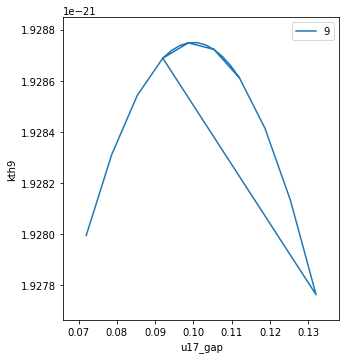

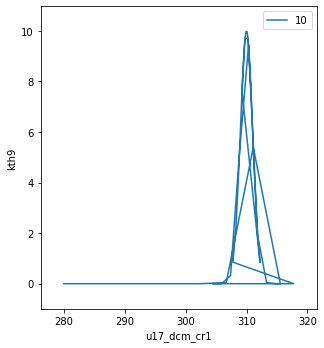

In [21]:
RE(dcm_change_energy(5000))


## Connection to real devices

In [ ]:
"""
from bessyii_devices.valve import PositionerBessyValve
from bessyii_devices.positioners import PVPositionerComparator
from bessyii_devices.keithley import Keithley6517
from ophyd import EpicsSignal, EpicsSignalRO, Component as Cpt
from bessyii_devices.undulator import UndulatorBase
from bessyii_devices.dcm import DCMEMIL as DCM


#The diode z travel
diode_z = PositionerBessyValve("DIODEY01U112L:",name = "diode_z")

#The keithely attached to that diode (Kth09)
kth09    = Keithley6517('EMILEL:' + 'Keithley09:',  name='kth09',read_attrs=['readback'])

#The undulator
u17   = UndulatorBase('U17IT6R:', name='u17')
u17.wait_for_connection()

# Monochromator
u17_dcm = DCM('', name='u17_dcm')
u17_dcm.wait_for_connection()
"""



# Moving from 415 to 412 uRad

using a settle time of 5 seconds seems apropriate 
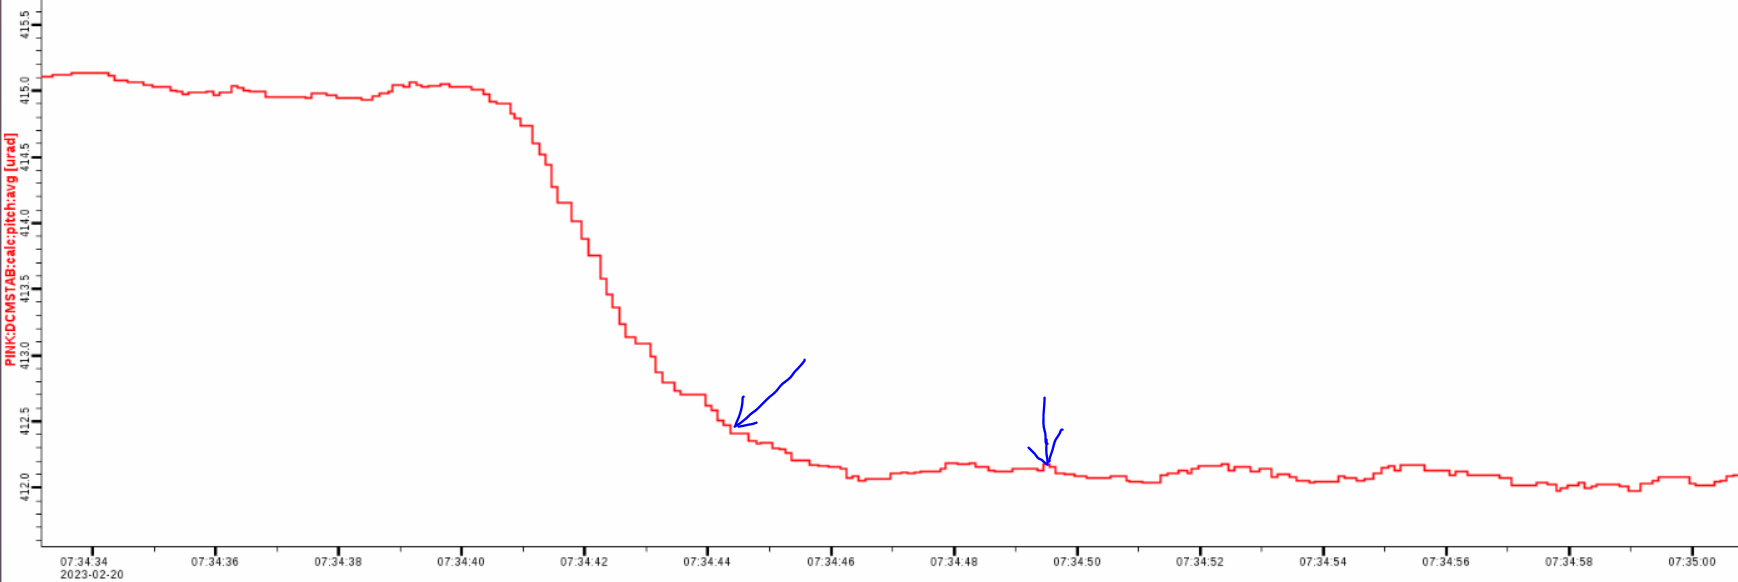

In [13]:
diode_z.status.read()

{'diode_z_status': {'value': 1, 'timestamp': 1676575497.955161}}

In [14]:
c2t_diff = abs(u17_dcm.c2t.setpoint.get() -u17_dcm.c2t.readback.get())

In [15]:
c2t_diff

11.094238999998197